# Landmask calibration
There are only a few settings for the landmask to adjust. We focus on the minimum and maximum sizes of holes to fill, the size and shape of the structuring element, and the effect of the structuring element shape on the speed of the processing.

In [4]:
using Pkg
Pkg.activate("calval")
using IceFloeTracker
using Images

  Activating project at `~/Documents/research/calval_tgrs/notebooks/calval`
[ Info: Precompiling IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] (cache misses: wrong dep version loaded (6), incompatible header (10), mismatched flags (2))


In [7]:
lm_test_img = load("../data/validation_dataset/modis_500km/landmask/001-baffin_bay-500km-20220911-250m-landmask.tiff");

In [8]:
eltype(lm_test_img)

RGBA{N0f8}

In [9]:
@time begin
    IceFloeTracker.create_landmask(lm_test_img)
end

  5.464318 seconds (7.86 M allocations: 429.717 MiB, 2.85% gc time, 16.12% compilation time)


(dilated = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], non_dilated = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

In [10]:
@time begin
    IceFloeTracker.create_landmask(lm_test_img, strel_box((99,99)))
end

  1.620374 seconds (1.09 M allocations: 85.091 MiB, 0.93% gc time, 15.43% compilation time)


(dilated = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], non_dilated = Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

## Speed difference
Using the customized structuring element results in the landmask creation taking 20 seconds for a 500 km by 500 km image, whereas with the optimized box element it takes 2 seconds. This is with multiple tries running the code, and different images, so it's not a precompilation issue.

Or is it? I tried this on my home computer, and the default was 5.4 seconds while the update was 1.6. Faster, but not as dramatically so.

In [11]:
default_lm = IceFloeTracker.create_landmask(lm_test_img)
box99_lm = IceFloeTracker.create_landmask(lm_test_img, strel_box((99,99)); fill_value_upper=Int64(1e6))
dia99_lm = IceFloeTracker.create_landmask(lm_test_img, strel_diamond((99,99)); fill_value_upper=Int64(1e6));

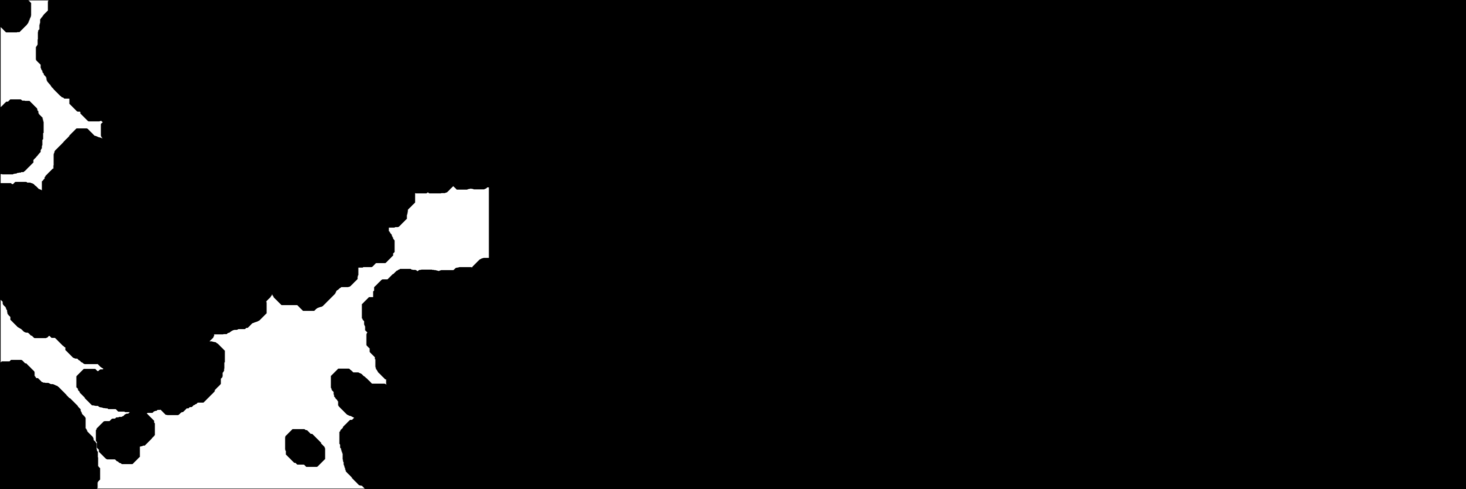

In [12]:
Images.mosaicview(
    Gray.(default_lm.dilated),
    Gray.(box99_lm.dilated),
    Gray.(dia99_lm.dilated), nrow=1)

## Comparison of quality
I'm personally not a fan of how any of these look, I think the radius is too large and we're going to miss interesting behavior near the coast. I'll note that the default results in a small inland pocket, as does the diamond, and we don't get that with the box.

In [13]:
box11_lm = IceFloeTracker.create_landmask(lm_test_img, strel_box((11,11)); fill_value_upper=Int64(1e4));
dia11_lm = IceFloeTracker.create_landmask(lm_test_img, strel_diamond((11,11)); fill_value_upper=Int64(1e4));

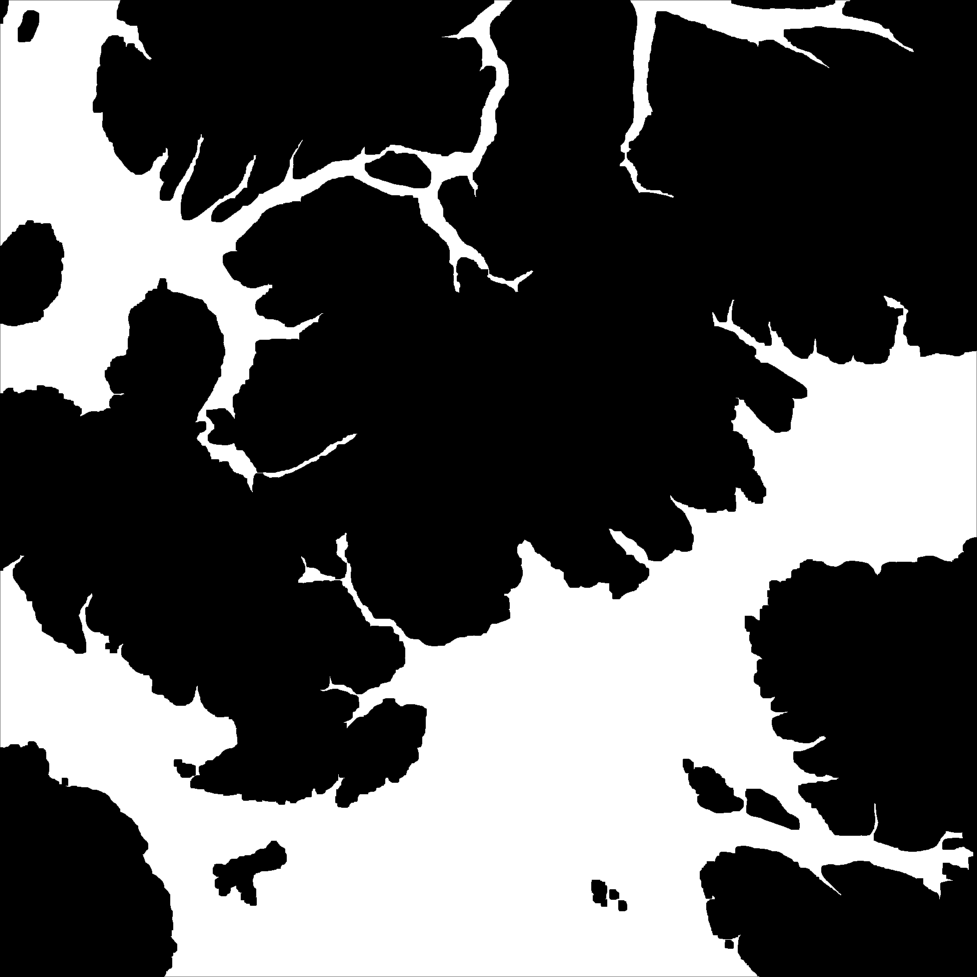

In [20]:
Gray.(box11_lm.dilated .& dia11_lm.dilated)

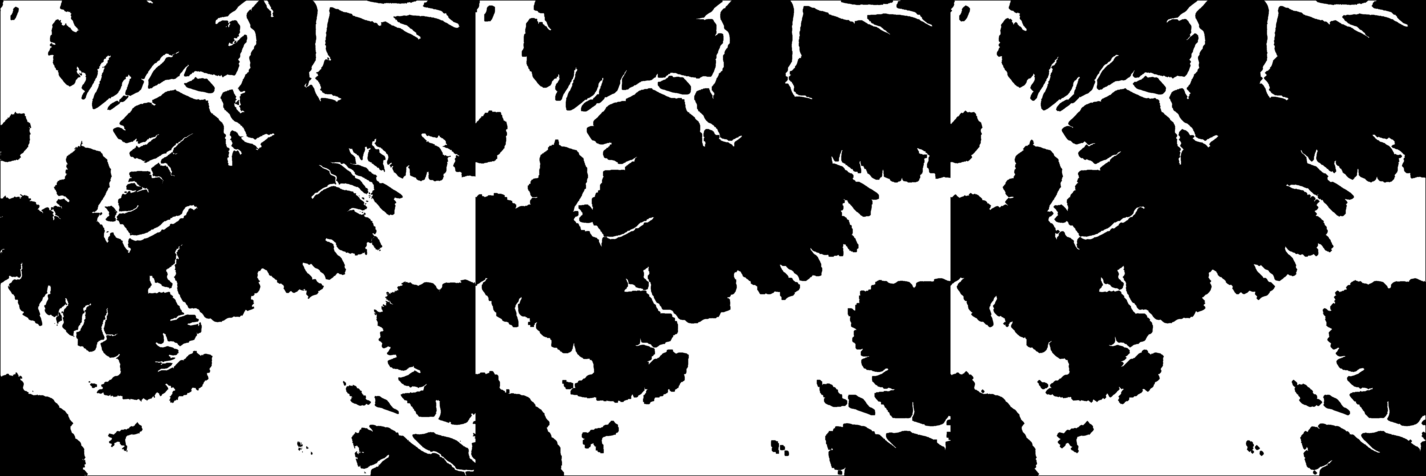

In [14]:
tile = (1:1900, 1:1900)
Images.mosaicview(
    Gray.(default_lm.non_dilated)[tile...],
    Gray.(box11_lm.dilated)[tile...],
    Gray.(dia11_lm.dilated)[tile...], nrow=1)

In [15]:
using Random

function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end

# Produce an image by replacing values inside a segment with the segment mean color
function view_seg(s)
    map(i->segment_mean(s,i), labels_map(s))
end

# Assign random colors to each segment (useful if viewing cluster results)
function view_seg_random(s)
    map(i->get_random_color(i), labels_map(s))
end

slm = SegmentedImage(lm_test_img, label_components(dia11_lm.dilated))

Segmented Image with:
  labels map: 1953×1953 Matrix{Int64}
  number of labels: 4

In [16]:
slm.segment_pixel_count

Dict{Int64, Int64} with 4 entries:
  0 => 2413942
  2 => 1072706
  3 => 36088
  1 => 291473